# Problem Set 5: Modeling Global Warming
# Introduction

President-elect Donald Trump ​said in 2012​ that he believed climate change was a hoax created by China. In this pset, we will attempt to prove him wrong. We will use regression analysis to model the climate of different areas in the United States in order to find evidence of global warming.
1. First, you will create models to analyze and visualize climate change in terms of temperature, and then consider ways to make the data less noisy and obtain clearer temperature change trends.
2. You will then test your models to see how well historical data can predict future temperatures.
3. Lastly, you will investigate a way to model the extremity of temperature, rather than just the increasing temperature.

# The Climate Class
To model the change in climate of a particular area, you will need some data. For this problem set, we will use temperature data obtained from the National Centers for Environmental Information (NCEI). The data, stored in ​data.csv​, contains the daily maximum and minimum temperatures observed in 21 U.S. cities from 1961 to 2015. Open the file, and take a look at the raw data.
In order to parse the raw data, in ​ps5.py​ ​we have provided a helper class, ​Climate​. You can initialize an instance of the ​Climate​ class by providing the name of the raw data file. Look over this class and read its docstrings to figure out how to get data for the following problems.

In [24]:
import numpy as np
import re # regular expressions module
from numpy.polynomial import polynomial 
import matplotlib.pyplot as plt

In [25]:
"""
Begin helper code
"""
class Climate(object):
    """
    The collection of temperature records loaded from given csv file
    """
    def __init__(self, filename):
        """
        Initialize a Climate instance, which stores the temperature records
        loaded from a given csv file specified by filename.

        Args:
            filename: name of the csv file (str)
        """
        self.rawdata = {}
        # rawdata is a dict of dicts, i.e rawdata[city] ={year:{month:{day:temp}}}
        f = open(filename, 'r')
        header = f.readline().strip().split(',')
        for line in f:
            items = line.strip().split(',')

            date = re.match('(\d\d\d\d)(\d\d)(\d\d)', items[header.index('DATE')])
            year = int(date.group(1))
            month = int(date.group(2))
            day = int(date.group(3))

            city = items[header.index('CITY')]
            temperature = float(items[header.index('TEMP')])
            if city not in self.rawdata:
                self.rawdata[city] = {}
            if year not in self.rawdata[city]:
                self.rawdata[city][year] = {}
            if month not in self.rawdata[city][year]:
                self.rawdata[city][year][month] = {}
            self.rawdata[city][year][month][day] = temperature
            
        f.close()

    def get_yearly_temp(self, city, year):
        """
        Get the yearly temperatures for the given year and city.

        Args:
            city: city name (str)
            year: the year to get the data for (int)

        Returns:
            a 1-d pylab array of daily temperatures for the specified year and
            city
        """
        temperatures = []
        assert city in self.rawdata, "provided city is not available"
        assert year in self.rawdata[city], "provided year is not available"
        for month in range(1, 13):
            for day in range(1, 32):
                if day in self.rawdata[city][year][month]:
                    temperatures.append(self.rawdata[city][year][month][day])
        return np.array(temperatures)

    def get_daily_temp(self, city, month, day, year):
        """
        Get the daily temperature for the given city and time (year + date).

        Args:
            city: city name (str)
            month: the month to get the data for (int, where January = 1,
                December = 12)
            day: the day to get the data for (int, where 1st day of month = 1)
            year: the year to get the data for (int)

        Returns:
            a float of the daily temperature for the specified time (year +
            date) and city
        """
        assert city in self.rawdata, "provided city is not available"
        assert year in self.rawdata[city], "provided year is not available"
        assert month in self.rawdata[city][year], "provided month is not available"
        assert day in self.rawdata[city][year][month], "provided day is not available"
        return self.rawdata[city][year][month][day]


In [26]:
def se_over_slope(x, y, estimated, model):
    """
    For a linear regression model, calculate the ratio of the standard error of
    this fitted curve's slope to the slope. The larger the absolute value of
    this ratio is, the more likely we have the upward/downward trend in this
    fitted curve by chance.
    
    Args:
        x: an 1-d pylab array with length N, representing the x-coordinates of
            the N sample points
        y: an 1-d pylab array with length N, representing the y-coordinates of
            the N sample points
        estimated: an 1-d pylab array of values estimated by a linear
            regression model
        model: a pylab array storing the coefficients of a linear regression
            model

    Returns:
        a float for the ratio of standard error of slope to slope
    """
    assert len(y) == len(estimated)
    assert len(x) == len(estimated)
    EE = ((estimated - y)**2).sum()
    var_x = ((x - x.mean())**2).sum()
    SE = np.sqrt((EE/(len(x)-2))/var_x)
    return SE/model[0]

In [27]:
def generate_models(x, y, degs):
    """
    Generate regression models by fitting a polynomial for each degree in degs
    to points (x, y).

    Args:
        x: an 1-d pylab array with length N, representing the x-coordinates of
            the N sample points
        y: an 1-d pylab array with length N, representing the y-coordinates of
            the N sample points
        degs: a list of degrees of the fitting polynomial

    Returns:
        a list of pylab arrays, where each array is a 1-d array of coefficients
        that minimizes the squared error of the fitting polynomial
    """
    # TODO
    models = []
    for deg in degs:
        model = polynomial.polyfit(x,y,deg)
        models.append(model)
    
    return models

In [28]:
def r_squared(y, estimated):
    """
    Calculate the R-squared error term.
    
    Args:
        y: 1-d pylab array with length N, representing the y-coordinates of the
            N sample points
        estimated: an 1-d pylab array of values estimated by the regression
            model

    Returns:
        a float for the R-squared error term
    """
    # TODO
    error = ((y-estimated)**2).sum()
    meanError = error/len(y)
    try :
        return 1- (meanError/np.var(y))
    except ZeroDivisionError:
        return 1

In [29]:
def evaluate_models_on_training(x, y, models):
    """
    For each regression model, compute the R-squared value for this model with the
    standard error over slope of a linear regression line (only if the model is
    linear), and plot the data along with the best fit curve.

    For the plots, you should plot data points (x,y) as blue dots and your best
    fit curve (aka model) as a red solid line. You should also label the axes
    of this figure appropriately and have a title reporting the following
    information:
        degree of your regression model,
        R-square of your model evaluated on the given data points,
        and SE/slope (if degree of this model is 1 -- see se_over_slope). 

    Args:
        x: an 1-d pylab array with length N, representing the x-coordinates of
            the N sample points
        y: an 1-d pylab array with length N, representing the y-coordinates of
            the N sample points
        models: a list containing the regression models you want to apply to
            your data. Each model is a pylab array storing the coefficients of
            a polynomial.

    Returns:
        None
    """
    # TODO
    for model in models:
        estimated = polynomial.polyval(x,model)
        plt.figure()
        plt.plot(x,y,'bo')
        plt.plot(x,estimated,'r')
        if len(model)==2:
            plt.title('Fit curve of degree' + ' ' + str(len(model)-1)+ ' '+ \
                  'R2 = '+ str(r_squared(y,estimated)) + '\n' + ' and SE/slope = ' +\
                      str(se_over_slope(x, y, estimated, model)))
        else:
            plt.title('Fit curve of degree' + ' ' + str(len(model)-1)+ ' '+ \
                  'R2 = '+ str(r_squared(y,estimated)))
        plt.xlabel('Years')
        plt.ylabel('Degrees in Celcius')


In [30]:
def gen_cities_avg(climate, multi_cities, years):
    """
    Compute the average annual temperature over multiple cities.

    Args:
        climate: instance of Climate
        multi_cities: the names of cities we want to average over (list of str)
        years: the range of years of the yearly averaged temperature (list of
            int)

    Returns:
        a pylab 1-d array of floats with length = len(years). Each element in
        this array corresponds to the average annual temperature over the given
        cities for a given year.
    """
    # TODO
    av_temp_per_year = []
    for year in years:
        av_temps_cities = np.array([climate.get_yearly_temp(city, year) for city in multi_cities])
        av_temp_per_year.append(np.mean(av_temps_cities))
        
    return np.array(av_temp_per_year)


In [31]:
def moving_average(y, window_length):
    """
    Compute the moving average of y with specified window length.

    Args:
        y: an 1-d pylab array with length N, representing the y-coordinates of
            the N sample points
        window_length: an integer indicating the window length for computing
            moving average

    Returns:
        an 1-d pylab array with the same length as y storing moving average of
        y-coordinates of the N sample points
    """
    # TODO
    moving_avg =[]
    for i in range(len(y)):
        if i - window_length+1 >= 0:
            moving_avg.append(np.mean(y[i-window_length+1:i+1]))
        else:
            moving_avg.append(np.mean(y[:i+1]))
    return np.array(moving_avg)


In [32]:
def rmse(y, estimated):
    """
    Calculate the root mean square error term.

    Args:
        y: an 1-d pylab array with length N, representing the y-coordinates of
            the N sample points
        estimated: an 1-d pylab array of values estimated by the regression
            model

    Returns:
        a float for the root mean square error term
    """
    # TODO
    return (((y - estimated)**2).sum()/len(y))**0.5

def gen_std_devs(climate, multi_cities, years):
    """
    For each year in years, compute the standard deviation over the averaged yearly
    temperatures for each city in multi_cities. 

    Args:
        climate: instance of Climate
        multi_cities: the names of cities we want to use in our std dev calculation (list of str)
        years: the range of years to calculate standard deviation for (list of int)

    Returns:
        a pylab 1-d array of floats with length = len(years). Each element in
        this array corresponds to the standard deviation of the average annual 
        city temperatures for the given cities in a given year.
    """
    # TODO
    stds_per_year = []
    for year in years :
        dayly_avg_temp_cities = []
        for month in range(1,13):
            try :
                for day in range(1,32):   
                    dayly_avg = np.array([climate.get_daily_temp(city, month, day, year)\
                              for city in multi_cities if day in climate.rawdata[city][year][month]])
                    if len(dayly_avg) > 0:
                        dayly_avg_temp_cities.append(np.mean(dayly_avg))
            except: AssertionError
        
        stds_per_year.append(np.std(np.array(dayly_avg_temp_cities)))
    return np.array(stds_per_year)


In [33]:
def evaluate_models_on_testing(x, y, models):
    """
    For each regression model, compute the RMSE for this model and plot the
    test data along with the model’s estimation.

    For the plots, you should plot data points (x,y) as blue dots and your best
    fit curve (aka model) as a red solid line. You should also label the axes
    of this figure appropriately and have a title reporting the following
    information:
        degree of your regression model,
        RMSE of your model evaluated on the given data points. 

    Args:
        x: an 1-d pylab array with length N, representing the x-coordinates of
            the N sample points
        y: an 1-d pylab array with length N, representing the y-coordinates of
            the N sample points
        models: a list containing the regression models you want to apply to
            your data. Each model is a pylab array storing the coefficients of
            a polynomial.

    Returns:
        None
    """
    # TODO
    for model in models :
        estimated = polynomial.polyval(x,model)
        root_2_mean = rmse(y, estimated)
        plt.figure()
        plt.plot(x,y,'bo')
        plt.plot(x,estimated,'r')
        plt.title('Test data points and best fit of degree '+ str(len(model)-1)+'\n' + \
                  'with RMSE = ' + str(root_2_mean))
        plt.xlabel('years')
        plt.ylabel('Average Temperatures in Celsius')


## CREATING MODELS

In [34]:
# cities in our weather data
CITIES = [
    'BOSTON',
    'SEATTLE',
    'SAN DIEGO',
    'PHILADELPHIA',
    'PHOENIX',
    'LAS VEGAS',
    'CHARLOTTE',
    'DALLAS',
    'BALTIMORE',
    'SAN JUAN',
    'LOS ANGELES',
    'MIAMI',
    'NEW ORLEANS',
    'ALBUQUERQUE',
    'PORTLAND',
    'SAN FRANCISCO',
    'TAMPA',
    'NEW YORK',
    'DETROIT',
    'ST LOUIS',
    'CHICAGO'
]

TRAINING_INTERVAL = range(1961, 2010)
TESTING_INTERVAL = range(2010, 2016)


In [35]:
filename = 'data.csv'
climate = Climate(filename)
x_training = np.array(TRAINING_INTERVAL, dtype = 'float')


# Part A.4
looking at averaged dayly temps

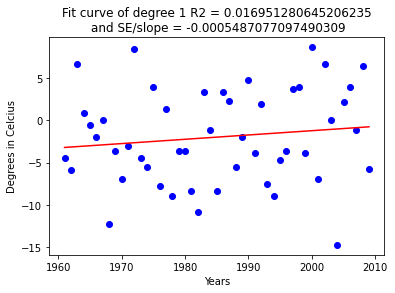

In [36]:
yvals1 = []
for year in TRAINING_INTERVAL :
    yvals1.append(climate.get_daily_temp('BOSTON', 1, 10, year))
yvals1 = np.array(yvals1)
model1 = generate_models(x_training, yvals1,[1])
evaluate_models_on_training(x_training, yvals1, model1)


# looking at averaged yearly tempertures


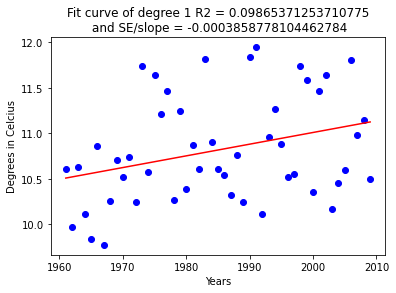

In [37]:
yvals2 = []
for year in TRAINING_INTERVAL :
    yvals2.append(np.mean(climate.get_yearly_temp('BOSTON',year)))
yvals2 = np.array(yvals2)
model2 = generate_models(x_training, yvals2, [1])
evaluate_models_on_training(x_training, yvals2, model2)


# Part B

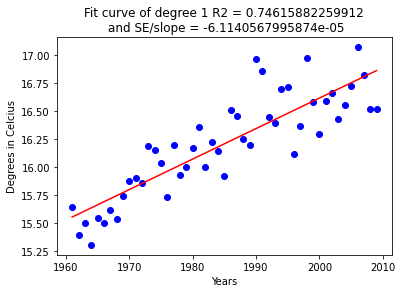

In [38]:
avg_temp_cities = gen_cities_avg(climate, CITIES, TRAINING_INTERVAL)
modelB = generate_models(x_training, avg_temp_cities, [1])
evaluate_models_on_training(x_training, avg_temp_cities, modelB)

# Part C
Use this function on the national yearly temperatures from 1961-2009 in order 
to generate the moving average temperatures with a window size of 5


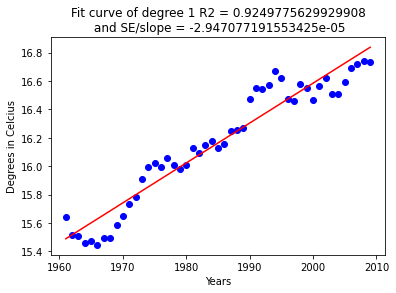

In [39]:
moving_avg_temps = moving_average(avg_temp_cities, 5)
modelC = generate_models(x_training, moving_avg_temps, [1])
evaluate_models_on_training(x_training, moving_avg_temps, modelC)


# Part D.2

# PREDICTING THE FUTURE:
We can’t use R 2 here, since R 2 does not have a clear meaning on testing data --
R 2 measures how closely a model matches the data used to generate the model, 
but we are generating the model with 1961-2009 and testing on 2010-2015.
One way to evaluate a model’s performance on test data is with Root Mean Square Error
(RMSE), which measures the deviation of predicted values from true values.
# =============================================================================
#   Problem 2.I Generate more models
First, we want to generate more models for prediction. Complete the following steps:
1. Compute 5-year moving averages of the national yearly temperature from 1961-2009 as your ​training​ data samples.
2. Fit the samples to polynomials of degree 1, 2 and 20.
3. Use ​evaluate models on training​ ​to plot your fitting results.


/Users/Juliana/anaconda3/envs/python38/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


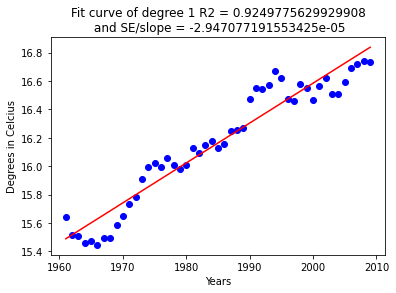

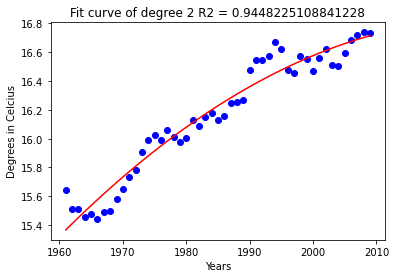

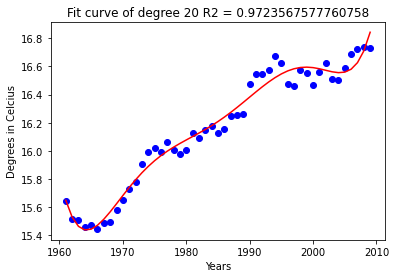

In [40]:
modelD = generate_models(x_training, moving_avg_temps, [1,2,20])
evaluate_models_on_training(x_training, moving_avg_temps, modelD)

# Predictions:
Now, let’s do some predictions and compare our predictions to the real average 
temperatures from 2010-2015. Complete the following steps:
1. Compute 5-year moving averages of the national yearly temperature from 2010-2015 as your test data samples.
2. For each model obtained in the previous problem (i.e., the curves fit to 5-year moving averages of the national yearly temperature from 1961-2009 with degree 1, 2, and 20), apply the model to your test data (defined above), and graph the predicted and the real observations (i.e., 5-year moving average of test data). You should use evaluate models on testing​ for applying the model and plotting the results.    


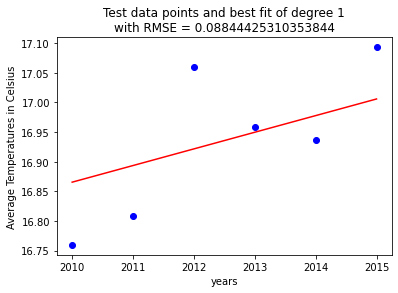

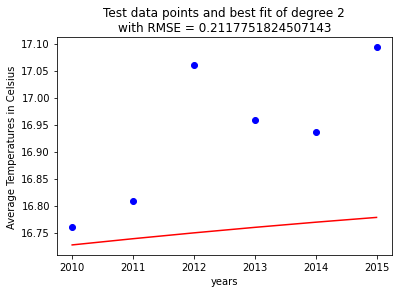

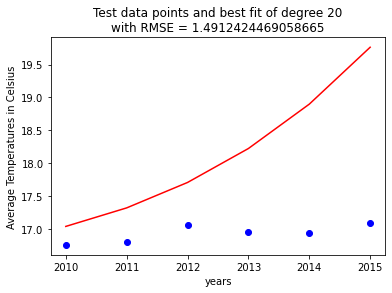

In [41]:
x_testing = np.array(TESTING_INTERVAL)
avg_temp_cities_test = gen_cities_avg(climate, CITIES, TESTING_INTERVAL)
mov_avg_temp_test = moving_average(avg_temp_cities_test, 5)
evaluate_models_on_testing(x_testing, mov_avg_temp_test, modelD)


If we had generated the models using the A.4.II data (i.e. average annual temperature of Boston) instead of the 5-year moving average over 22 cities, how would the prediction results 2010-2015 have changed?


/Users/Juliana/anaconda3/envs/python38/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


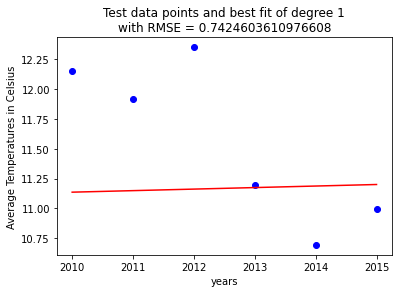

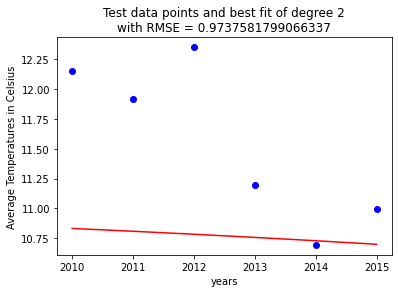

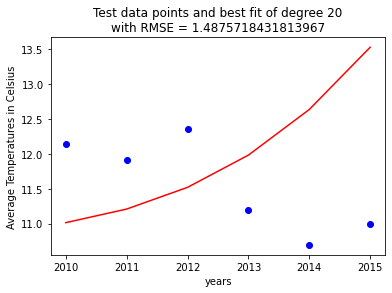

In [42]:
yvals2_testing = [] # list of avg yearly temps in years 2010-2015
for year in TESTING_INTERVAL :
    yvals2_testing.append(np.mean(climate.get_yearly_temp('BOSTON',year)))
yvals2_testing = np.array(yvals2_testing)  

modelD2 = generate_models(x_training, yvals2, [1,2,20])
evaluate_models_on_testing(x_testing, yvals2_testing, modelD2)


# Part E: Modeling Extreme Temperatures

In addition to raising temperature, global warming also makes temperatures 
more extreme (e.g., very hot or very cold). We surmise that we can model this effect 
by measuring the standard deviation in our data. A small standard deviation would 
suggest that the data is very close together around the mean. 
#
A larger standard deviation, however, would suggest that the data varies a lot  (i.e., more extreme weather). Therefore, we expect that over time, the standard deviation should increase.

1. Use ​gen_std_devs​ to compute the standard deviations using all 21 cities over the years in the training interval, 1961-2009.
2. Compute 5-year moving averages on the yearly standard deviations.
3. Finally, ​fit your data to a degree-one polynomial with ​generate_models​ and plot the regression results with ​evaluate models on training​


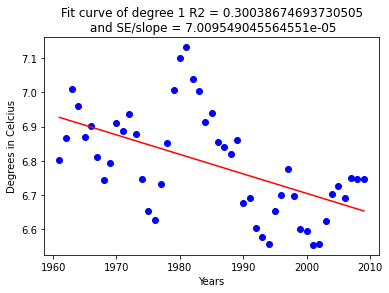

In [43]:
#CITIES = ['BOSTON']
stds_per_year_training = gen_std_devs(climate, CITIES, TRAINING_INTERVAL)
mov_avg_of_stds_training = moving_average(stds_per_year_training, 5)
modelE = generate_models(x_training, mov_avg_of_stds_training, [1])
evaluate_models_on_training(x_training, mov_avg_of_stds_training, modelE)
